## Result Analysis
Let's first load and plot the training loss

The loss does seem to fall substantially from ~3.25 to ~0.18, most of this progress is within the first 1000 training epochs, again this is not unexpected

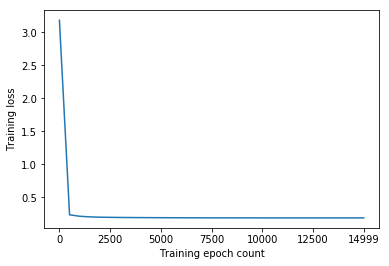

In [3]:
import numpy as np
from os.path import expanduser
import matplotlib.pyplot as plt
# enable in-line plotting in notebook
%matplotlib inline

homeDir = expanduser('~') 
lossFilepath = '{}/Data/morsum/training.csv'.format(homeDir)
trainingLossEntries = np.loadtxt(lossFilepath, delimiter=',')
epochs = trainingLossEntries[:,0].astype(int)
losses = trainingLossEntries[:,1]
del trainingLossEntries # delete original data to save memory

# to avoid use of the pyplot package I initially just printed the loss value over time
plt.plot(losses)
plt.ylabel('Training loss')
plt.xlabel('Training epoch count')
xTickIndices = np.arange(7)*5
plt.xticks(xTickIndices, epochs[xTickIndices])
plt.show()

### Comparing predictions to targets
Considering the average distance between the targets and the predictions, it looks like the model has done a fairly good job in learning a relationship, dispite the simple approach

In [38]:
outputFilepath = '{}/Data/morsum/output.csv'.format(homeDir)
output = np.loadtxt(outputFilepath, delimiter=',')
targets = output[0]
predictions = output[1]
del output # delete original data to save memory

print('Predictions:\t{}'.format(np.around(predictions[:10], 2)))
print('Targets:\t{}'.format(targets[:10]))
print('Average distance: {}'.format(np.mean(np.abs(targets - predictions))))

Predictions:	[2.03 1.35 1.38 1.82 1.21 1.8  1.26 1.41 1.37 1.78]
Targets:	[2.02 1.33 1.05 2.29 1.75 1.58 0.88 1.83 1.03 2.19]
Average distance: 0.185598314257


We can assess the performance more accurately with more advanced statistical measures

In [39]:
def calculate_r_squared(predictions, targets):
    SSres = np.sum((targets - predictions)**2)
    SStot = np.sum((targets - np.mean(targets, axis=0))**2)
    return np.mean(1 - SSres / SStot)

calculate_r_squared(predictions, targets)

0.6412903594047259

The $r^{2}$ metric calculates how much of the variance in the target is explained by the model. It can be interpreted like a percentage, so the value above shows that our model explains around 64% of the variance. While this is well above chance, there is still much room for improvement

### Evaluating useful features
A simple metric we can use to rank feature importance is to examine the attached coefficients generated by the model. While this can only be strictly accurate when we more rigorously standardise our input features (i.e. 0-mean them), it should give us a rough guide of what is important

In [59]:
modelFilepath = '{}/Data/morsum/model.csv'.format(homeDir)
model = np.loadtxt(modelFilepath, delimiter=',')

print('Epoch coefficient:\t\t{}'.format(abs(model[1])))

# I think the mean of the one-hot features is the most appropriate way to assess their importance
monthIndices = range(2,14)
print('Month coefficient:\t\t{}'.format(abs(np.mean(model[monthIndices]))))
print('Total volume coefficient:\t{}'.format(abs(model[14])))
print('4046 coefficient:\t\t{}'.format(abs(model[15])))
print('4225 coefficient:\t\t{}'.format(abs(model[16])))
print('4770 coefficient:\t\t{}'.format(abs(model[17])))
print('Total bags coefficient:\t\t{}'.format(abs(model[18])))
print('Small bags coefficient:\t\t{}'.format(abs(model[19])))
print('Large bags coefficient:\t\t{}'.format(abs(model[20])))
print('Xlarge bags coefficient:\t{}'.format(abs(model[21])))
print('Type coefficient:\t\t{}'.format(abs(np.mean(model[[22,23]]))))
print('Region coefficient:\t\t{}'.format(abs(np.mean(model[23:]))))

Intercept coefficient:		0.674134069977
Epoch coefficient:		0.191630400557
Month coefficient:		0.860488827502
Total volume coefficient:	0.117332859943
4046 coefficient:		0.0769137000323
4225 coefficient:		0.11794464219
4770 coefficient:		0.215081790591
Total bags coefficient:		0.0562646964769
Small bags coefficient:		0.124383139138
Large bags coefficient:		0.106553924158
Xlarge bags coefficient:	0.448879455981
Type coefficient:		0.162932965011
Region coefficient:		0.958818172515


The top 3 features by importance are region, month, and Xlarge bags. 

The cost-of-living in different areas is a significant factor in grocery prices, so it is no surprise that the region which would encode this information performed well

As expected during the initial data inspection, the month proved a much more effective feature than the date. I expect this is due to change in price following whether or not the avocado is in season

The Xlarge bags feature was something of a surprise to me, my first thought was that establishments selling more Xlarge bags are more likely to be wholesellers, and thus have a lower price than other smaller shops. If this were the case it would have a high magnitude negative coefficient, however when I remove the *abs()* term (as below) the value is still positive. I don't have a good explanation for this, perhaps I misunderstand what the feature means

In [62]:
print('Xlarge bags coefficient:\t{}'.format(model[21]))

Xlarge bags coefficient:	0.448879455981
